<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

**Example 2- Numerical functions**

In many applications we have do not have access to an analytic functions $Y(\mathbf{x})$, but rather we have the ability to evaluate them at an arbitrary set of quadrature points $\{\mathbf{x}_q\}$. Given that our approach to computing CDF the of $Y(\mathbf{x})$
\begin{equation*}
    F(y) = \int_{\Omega} \mathbb{I}(y,\mathbf{x}) d \mathbf{x},
\end{equation*}
utilises numerical quadrature in order to evaluate a projection of the indicator function given by
\begin{equation*}
    \mathbb{I}(y,\mathbf{x}) =
    \begin{cases}
    1 \quad &: Y(\mathbf{x}) < y, \\
    0 \quad &: \text{otherwise},
    \end{cases}
\end{equation*}
this implies that by using a sufficiently high degree of numerical quadrature we can exploit the functional form of $Y(\mathbf{x})$. In instances where the function is calculated using a pseudo-spectral or finite element method this is therefore particularly powerful.

In this notebook we consider two different examples. The first demonstrates our method on a 2D function $Y(\mathbf{x})$ specified in terms of numpy functions, while the second shows how to calculate the CDF from externally generated data such as from a numerical simulation. To begin implementing these examples we first import *firedrake* and *Ptp*.

In [1]:
from numdf import Ptp
from firedrake import *
import matplotlib.pyplot as plt 

**A) Lorenz model**

We consider the function 
\begin{equation}
Y(\mathbf{X})  = \frac{\sqrt{2}}{\pi r} \cos(k X_1) \sin( \pi X_2) - \frac{1}{ r \pi} \sin(2 \pi X_2),
\end{equation}
corresponding to the buoyancy field used in the Lorenz (1963) model, for which we set the parameters $r=28, k = \pi/\sqrt{2}$. We implement this below in terms of numpy arrays

In [2]:
import numpy as np

# Parameters
r = 28 
k = np.pi/2**.5

def Y_numerical(X):
    """Return Y(X)."""
    x1, x2 = X[:,0], X[:,1]
    return ( 2**.5/(np.pi*r) ) * np.cos(k*x1) * np.sin(np.pi*x2) - ( 1/(np.pi*r) ) * np.sin(2*np.pi*x2)

which is then visualised below on a grid to establish the range of $Y(\mathbf{x})$.

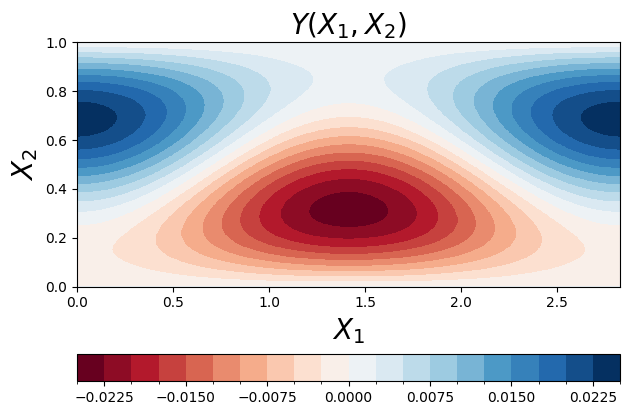

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

x = np.linspace(0, 2*np.pi/k, 10**3)
z = np.linspace(0, 1, 10**3)
[x1, x2] = np.meshgrid(x,z, indexing='ij')

X = np.vstack( (x1.flatten(), x2.flatten())).T
Y = Y_numerical(X).reshape(x2.shape)[:-1, :-1]

levels = MaxNLocator(nbins=20).tick_values(Y.min(), Y.max())
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax0 = plt.subplots()
im = ax0.pcolormesh(x1, x2, Y, cmap=cmap, norm=norm)
ax0.set_title(r'$Y(X_1,X_2)$',fontsize=20)
ax0.set_xlabel(r'$X_1$',fontsize=20)
ax0.set_ylabel(r'$X_2$',fontsize=20)
ax0.set_box_aspect(1/k)
fig.colorbar(im, ax=ax0, orientation='horizontal')
fig.tight_layout()
plt.show()

To approximate the cdf of $Y(\mathbf{x})$ using NumDF we first create a *Ptp* object by specifying the domain and range of the function.

In [4]:
y_min = -0.024
y_max =  0.024
ptp = Ptp(Omega_X={'x1': (0, 2*np.pi/k), 'x2': (0, 1)}, Omega_Y={'Y': (y_min, y_max)}, n_elements=200)

We can then pass *Y_numerical* directly to *ptp.fit()* which identifies it as a python callable. This method can then evaluate $Y(\mathbf{x})$ on a *Quadrature Element* using a number of points directly determined by the *quadrature_degree* parameter.

In [5]:
density = ptp.fit(Y_numerical, quadrature_degree=1000)

To verify that our computations we "compare" the estimated CDF with the analytical CDF whose calculation and details are outlined in appendix A and B of [Craske J., & Mannix P. (2024)](https://arxiv.org/abs/2408.08028). The plot below which shows the CDF and the $L^1$ projection of the PDF demonstrates our method's prediction closely matches the analytical estimate, despite the presence of singularities.


/tmp/ipykernel_38852/2836009843.py:21: RuntimeWarning: invalid value encountered in power
  fx = (-1/(k*A*np.sin(π*x)) )*np.pow( 1 - (y_i + B*np.sin(2*π*x))**2/(A*np.sin(π*x))**2, -1/2 )


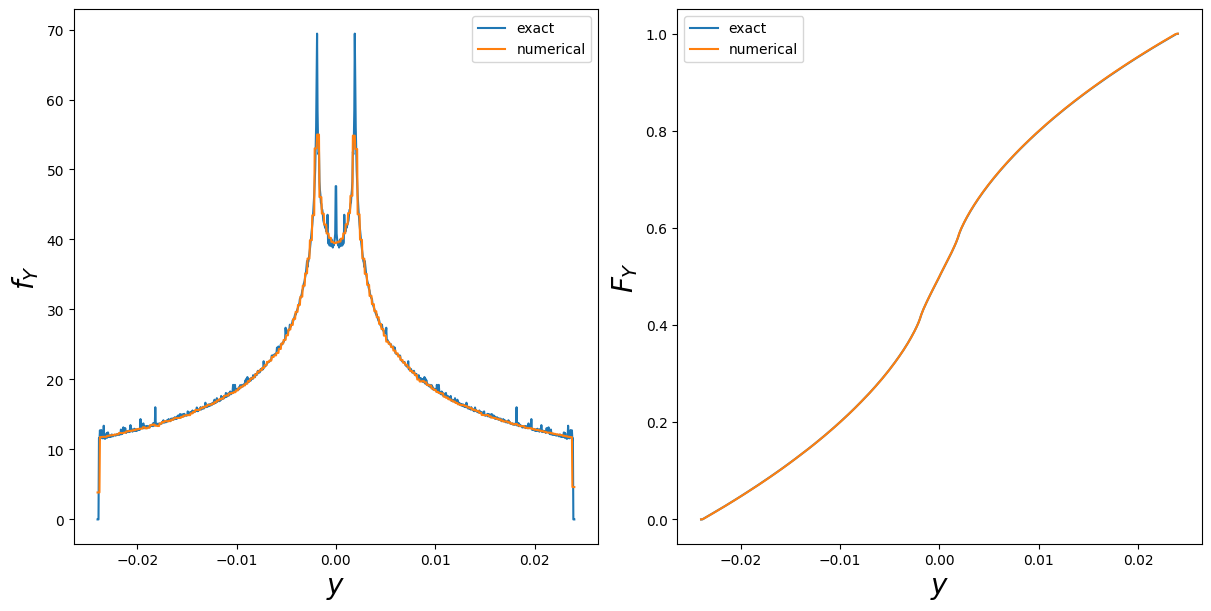

In [6]:
def lorenz_density(n=10**3):
    """
    Return f_Y,F_Y of the system

    Y(X1,X2) = A*cos(k.X1).sin(pi.X2) - B*sin(2 pi.X2) 
    
    following the methods outlined in Appendix B of Craske J. & Mannix P. (2024).
    """
    from scipy.integrate import cumulative_trapezoid

    π = np.pi
    A = 2**.5/(np.pi*r)
    B = 1/(np.pi*r)
    Lx1 = 2**.5
    
    eps = 1e-06
    x, dx = np.linspace(eps,1-eps,10*n, retstep=True)
    y = np.linspace(y_min,y_max,n)
    f = 0*y
    for i,y_i in enumerate(y):
        fx = (-1/(k*A*np.sin(π*x)) )*np.pow( 1 - (y_i + B*np.sin(2*π*x))**2/(A*np.sin(π*x))**2, -1/2 )
        f[i] = (1/Lx1)*np.nansum(abs(fx))*dx

    # Compute the CDF
    F = cumulative_trapezoid(y=f,x=y,initial=0)

    return f,F,y

# Obtain the semi-analytical denisty
f,F,y = lorenz_density(n=(10**3))

# Obtain the ptp estimate of the density
F_num = np.asarray(density.cdf.at(y))
f_num = np.asarray(density.pdf['f_tilde'].at(y))

# Comapre the analytical and estimated density
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), layout='constrained')

ax[0].plot(y,f,label='exact')
ax[0].plot(y,f_num,label='numerical')
ax[0].set_ylabel(r'$f_Y$',fontsize=20)
ax[0].set_xlabel(r'$y$',fontsize=20)
ax[0].legend()

ax[1].plot(y,F,label='exact')
ax[1].plot(y,F_num,label='numerical')
ax[1].set_ylabel(r'$F_Y$',fontsize=20)
ax[1].set_xlabel(r'$y$',fontsize=20)

ax[1].legend()

plt.show()


**B) Kelvin-Helmholtz instability**

For the second example we will compute the CDF of the buoyancy field $B(\mathbf{x})$ of a time evolving simulation of the Kelvin-Helmholtz instability generated using [Dedalus](https://dedalus-project.org/). The dataset we use contains snapshots at $T=[1,2, \cdots, 24]$ while the simulation details, equations and Dedalus script are available in the folder $\texttt{KelvinHelmholtz}$. Following the previous example we write a function *Y_numerical* which returns the value of the function at a set of quadrature points.

In [7]:
import h5py
from scipy.interpolate import RegularGridInterpolator

Times = [16, 20, 24]

def Y_numerical(X, time=2):
    """Return Y(X)."""

    f = h5py.File('data/KelvinHelmholtz/snapshots_s1.h5','r')
    Y = f['tasks/buoyancy'][time, ...]
    x = f['tasks/buoyancy'].dims[1][0][:]
    z = f['tasks/buoyancy'].dims[2][0][:]
    f.close()

    return RegularGridInterpolator((x, z), Y, bounds_error=False)(X)

Using *Y_numerical* we then plot snapshots of this data at different time-instants on a regular grid

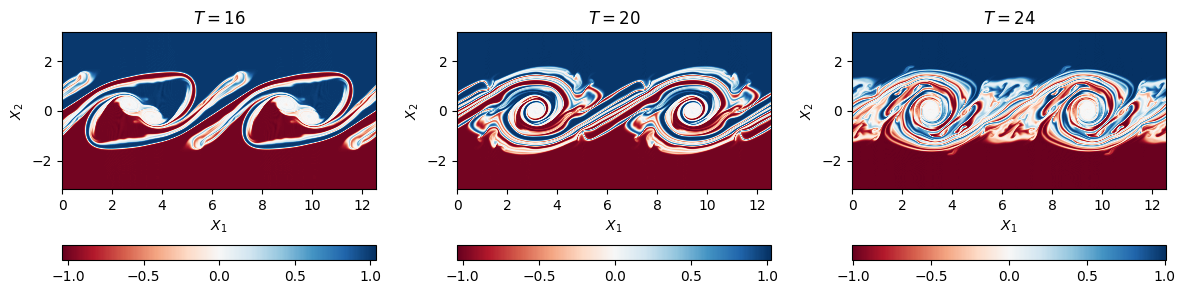

In [8]:
dx1, dx2 = 0.01, 0.01
x2, x1 = np.mgrid[slice(-np.pi,np.pi + dx1, dx1), slice(0, 4*np.pi + dx2, dx2)]
X = np.vstack( (x1.flatten(), x2.flatten())).T

fig, ax = plt.subplots(ncols=3,figsize=(12,4))

for ax0,time in zip(ax, Times):

    Y = Y_numerical(X,time).reshape(x2.shape)[:-1, :-1]

    cmap = plt.get_cmap('RdBu')
    im = ax0.pcolormesh(x1, x2, Y, cmap=cmap)
    ax0.set_title(r'$T=%d$'%time)
    ax0.set_xlabel(r'$X_1$')
    ax0.set_ylabel(r'$X_2$')
    ax0.set_box_aspect(0.5)
    fig.colorbar(im, ax=ax0, orientation='horizontal')

fig.tight_layout()
plt.show()

To generate the CDF of this field we create a *Ptp* object which specifies the domain size, the function's range and the number of finite elements. In this example we have intentionally chosen the number of elements and domain size such that the maximum and minimum of the field $Y(\mathbf{x})$ namely $-1,1$ coincide with element facets. This is chosen in order to capture the Dirac measures which we anticipate will occur at these points.

In [69]:
ptp = Ptp(Omega_X={'x1': (0, 4*np.pi), 'x2': (-np.pi, np.pi)}, Omega_Y={'Y': (-1.1,1.1)}, n_elements=88)

We then create a *density* object by selecting the quadrature degree and calling the fit method on each snapshot. Finally we plot the time evolution of the CDF below.

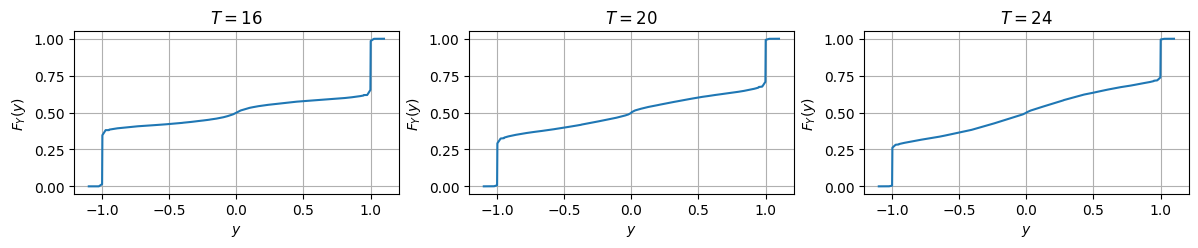

In [70]:
fig, ax = plt.subplots(ncols=3,figsize=(12,4))

y = np.linspace(-1.1, 1.1, 10**3)

PDFs = []
for ax0,time in zip(ax, Times):

    Y = lambda X: Y_numerical(X,time=time)
    density = ptp.fit(Y, quadrature_degree=500)

    F = np.asarray(density.cdf.at(y))
    f = np.asarray(density.pdf['f_tilde'].at(y))

    PDFs.append(f)

    ax0.plot(y,F)
    ax0.set_title(r'$T=%d$'%time)
    ax0.set_ylabel(r'$F_Y(y)$')
    ax0.set_xlabel(r'$y$')
    ax0.set_box_aspect(0.5)
    ax0.grid()
  
fig.tight_layout()
plt.show()

The initial CDF corresponds a step function describing the two layer stratification. As the Kelvin-Helmholtz instability evolves these layers are mixed. This causes the CDF to tilt and evolve towards a stable stratification of uniform buoyancy. To visualize this process we can also compute the PDF whose $L^1$ projection is plotted below. As buoyancy fields often consist of uniform and mixed regions we consider how to compute the APE of such a function in the next section.

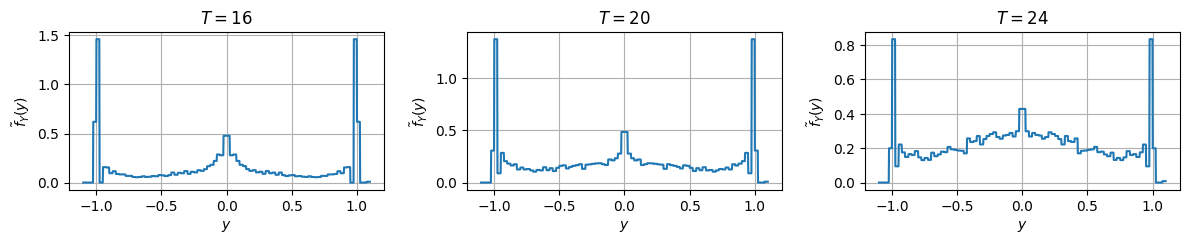

In [71]:
fig, ax = plt.subplots(ncols=3,figsize=(12,4))

for ax0,time,f in zip(ax, Times, PDFs):

    ax0.plot(y, f)
    ax0.set_title(r'$T=%d$'%time)
    ax0.set_xlabel(r'$y$')
    ax0.set_ylabel(r'$\tilde{f}_Y(y)$')
    ax0.set_box_aspect(0.5)
    ax0.grid()

fig.tight_layout()
plt.show()